## EU Big Data Hackathon 2019

### Team UK solution: Have you got too much on your plate?
<td>
Thanasis Anthopoulos, Alessandra Sozzi, Rhydian Page




1. Motivation
2. Data
3. Proposed solution
4. Limitations
5. Feature improvements
6. Conclusion

## Motivation

Why did we choose this idea?
* Respondants of the TUS are asked only what they are doing every 10 minutes, they may say if they are eating or not
* But no other information are provided
* Survey has missing data
* Can we lower the burden for survey respondants?
* Can other data be derived rather than asked to respondants?
* Can we enrich the information on food consumption, health and well-being?

## Data

Self reported images of respondants meals collected through the BigO app: respondants are asked to take a picture of their meals and add some extra information to it (eg: meal type - breakfast, lunch, etc - and others)


## Proposed solution

Data: Self reported images of respondants meals collected through the BigO app

1. Tag the images using Computer Vision

2. NLP on the tags and Categorisation

3. Enriching the Statistical Information

### 1. Tag the images

* Use Artificial Intelligence to generate textual descriptions of images: using existing models or train an entire new model to suit our needs
* For the purposes of this hackathon we chose the pretrained Google model available through the Google Vision API, bacause of its ease of use. 
* The image is run through the model which output the tags 
<table>
<tr>
<td>
<img src='./dataset/big0/self_reports/829/meals/6.jpg' height=200 width=200></img>
</td>
<td>
Dish, Food, Hamburger, Junk food, Cuisine, Fast food, <br>Ingredient, Fried food, Whopper, Veggie burger
</td>
</tr>
</table>

### 2. NLP on the tags and Categorisation
* The tags describe the whole picture, which might include non food items
* We experimented with various NLP techniques to extract the desired information from the general tags



#### Approach 1:
We processed the meal descriptions eg: Identify stopwords using techniques such as LDA
1. Used a pre-defined set of categories: fruit_veg, starchy, protein, fat_sugars, dairy
2. Use FastText trained in the Wikipedia corpus to embed (create vector representation) of the image descriptions and categories
3. Calculate the pair-wise distance between vector representations of tags and categories
4. For each category we keep the distance that match the category the most to categorise the meal in the image


##### An example of the output
<table>
<tr>
<td>
<img src='./imgs_fasttext/833_9.jpg' height=400 width=400></img>
</td>
<td>
<code>
predefined_tags = {
            'fruit_veg': ['fruit', 'vegetables'],
            'starchy': ['bread', 'rice', 'pasta', 'potatoes'],
            'protein': ['meat', 'egg', 'fish', 'beans', 'legumes'],
            'fat_sugars': ['cake', 'junk'],
            'dairy': ['milk', 'cheese', 'yoghurt']}
</code>
</td>
</tr>
</table>

#### Approach 2:

* We trained a Doc2Vec model using a 50-dimensional vector space to produce meaningful embeddings: find descriptions that are semantically similar (closer in space)

* Descriptions are transformed into numerical features and can be visualised using dimensionality reduction (such as t-SNE) to two dimensional space

* We classified meals into similar meal types using clustering (tried kmeans, HDBSCAN)

In [5]:
%matplotlib inline

import string
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import eu_hack_as as eu
import random
import hdbscan
import seaborn as sns
import re
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from gensim.models.doc2vec import LabeledSentence

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import warnings
warnings.filterwarnings("ignore")

users_dict = eu.read_dict_from_pickle()

# The Doc2Vec model requires that both the document labels and strings are in a list format

unpacked = [(user_key + '_' + meal_key, meal_value) 
         for user_key, user_meals in users_dict.items() 
         for meal_key, meal_value in user_meals.items()]

docLabels, descriptions = zip(*unpacked)

model = gensim.models.Doc2Vec.load('./models/doc2vec.model')

In [6]:
# use t-SNE for dimensionality reduction with a cosine similarity measure & plot
docvecs = list(model.docvecs)
tsne = manifold.TSNE(n_components=2, init='random', metric='cosine', random_state=None, method='barnes_hut')

tsne_model = tsne.fit_transform(docvecs)

# Create a trace
trace = go.Scatter(
    x = tsne_model[:, 0], 
    y = tsne_model[:, 1],
    mode = 'markers',
    text=[' '.join(d) for d in descriptions],
    textposition='top center'
)

data = [trace]

layout = go.Layout(
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)

In [7]:
# Embedded meals description
iplot( fig )  

### 3. Enriching the Statistical Information
We matched our text descriptions to a database of dishes with attached nutritional information and add this information to our dataset. Nutritional values are provided with respect to typical serving weight, but we can always compute nutritional values for 100g 

An example:
<table>
<tr>
    <td>
    **Name**: **hamburger**
    <br>
    <br>
    **Serving Weight**: 226 
    <br>
    **Calories**: 540.14
    <br>
    **Protein**: 34.28 
    <br>
    **Total Carbohydrates**: 40.27 
    <br>
    **Total Fat**: 26.56 
    <br>
    **Potassium**: 569.52 
    <br>
    **Sodium**: 791 
    <br>
    **Cholesterol**: 122.04 
    <br>
    </td>
    <td>
    **Categories:**
    <br>
    **fat_sugars: 1.0**
    <br>
    **proteins:** 0.6
    <br>
    **fruit_veg:** 0.59
    <br>
    **dairy:** 0.55
    <br>
    **starchy:** 0.51
    </td>
    <td>
    <img src='./dataset/big0/self_reports/829/meals/6.jpg' height=150 width=150></img>
    </td>
</tr>
</table>

In [29]:
users = pd.read_csv("special_users.csv", index_col=0)
users

,Name,Calories,Protein,Total Carbohydrates,Total Fat,Potassium,Sodium,Cholesterol,Serving Weight,path_to_image
825_0,chicken meat,266.00,40.50,0.00,10.37,340.20,120.40,124.60,146.00,./dataset/big0/self_reports/825/meals/0.jpg
825_1,whipped cream,15.42,0.19,0.75,1.33,8.82,0.48,4.56,3.00,./dataset/big0/self_reports/825/meals/1.jpg
825_2,roll,76.44,2.41,12.88,1.76,32.20,146.72,0.00,28.00,./dataset/big0/self_reports/825/meals/2.jpg
825_3,cheese,113.12,6.40,0.87,9.33,21.28,182.84,27.72,28.00,./dataset/big0/self_reports/825/meals/3.jpg
825_4,empanada,743.70,25.11,69.24,40.78,421.80,976.80,57.72,89.00,./dataset/big0/self_reports/825/meals/4.jpg
840_1,full breakfast,894.59,44.37,33.86,65.84,889.39,2034.30,369.33,435.96,./dataset/big0/self_reports/840/meals/1.jpg
840_2,scrambled eggs,90.89,6.09,0.98,6.70,80.52,88.45,168.97,61.00,./dataset/big0/self_reports/840/meals/2.jpg
840_3,cheese,113.12,6.40,0.87,9.33,21.28,182.84,27.72,28.00,./dataset/big0/self_reports/840/meals/3.jpg
840_4,meat,255.82,31.28,0.01,13.52,328.85,79.61,104.10,113.40,./dataset/big0/self_reports/840/meals/4.jpg


In [37]:
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML

pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((100, 100), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

users['image'] = users.path_to_image.map(lambda f: get_thumbnail(f))
user_1 = users.iloc[:5]
user_1['categories > 0.75'] = ['proteins', 'dairy', 'starchy', 'dairy starchy', 'starcy']
user_2 = users.iloc[5:]
user_2['categories > 0.75'] = ['proteins', 'proteins', 'dairy', 'proteins']

,Name,Calories,Protein,Total Carbohydrates,Total Fat,Potassium,Sodium,Cholesterol,Serving Weight,image,categories > 0.75
825_0,chicken meat,266.00,40.50,0.00,10.37,340.20,120.40,124.60,146.0,,proteins
825_1,whipped cream,15.42,0.19,0.75,1.33,8.82,0.48,4.56,3.0,,dairy
825_2,roll,76.44,2.41,12.88,1.76,32.20,146.72,0.00,28.0,,starchy
825_3,cheese,113.12,6.40,0.87,9.33,21.28,182.84,27.72,28.0,,dairy starchy
825_4,empanada,743.70,25.11,69.24,40.78,421.80,976.80,57.72,89.0,,starcy

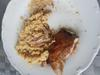
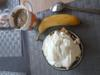
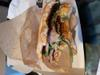
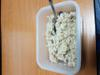
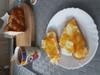

In [38]:
# Example User 825
HTML(user_1.drop('path_to_image', axis=1).to_html(formatters={'image': image_formatter}, escape=False))

,Name,Calories,Protein,Total Carbohydrates,Total Fat,Potassium,Sodium,Cholesterol,Serving Weight,image,categories > 0.75
840_1,full breakfast,894.59,44.37,33.86,65.84,889.39,2034.30,369.33,435.96,,proteins
840_2,scrambled eggs,90.89,6.09,0.98,6.70,80.52,88.45,168.97,61.00,,proteins
840_3,cheese,113.12,6.40,0.87,9.33,21.28,182.84,27.72,28.00,,dairy
840_4,meat,255.82,31.28,0.01,13.52,328.85,79.61,104.10,113.40,,proteins

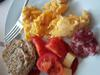
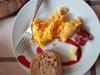
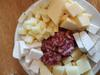
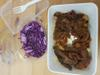

In [39]:
# Example User 840
HTML(user_2.drop('path_to_image', axis=1).to_html(formatters={'image': image_formatter}, escape=False))

## Limitations

1. The image tagger relies on the quality of the images: some images could not be tagged because poor quality, very dark, the picture wasn't of food, occlusions (some food occludes another so cannot be seen)
2. And as a consequence this might restrict the NLP task and its output
3. Easier to take a picture of your meal or describing it in the survey?
4. We don't know how big the portion is (although another visual task could be to estimate it) and we don't know how much the user has eaten of it

## Future improvements

* Our solution relies on models that are on continuous improvement
* This pipeline could be used on external sources such as Twitter/Instagram to analyse different countries eating habits
* From the images multiple foods can be detected and multiple nutrients for the different food can be attached
* Could compare eating habits and compare it with exercise activities/calories burned derived from the app
* Could explore other models: eg imageToRecipe
* With a timeseries of data you could do a propagation analysis on the clusters to watch them change shape over time

## Conclusions

* Results are sensible despite small sample
* it could be used to enrich the TUS data on food consumptions ...
* ... with less burden to the respondant: the user does not to say anything about the image, an image is worth a thousands words!
* people self reporting on food consumption tend to be biased as several studies suggest
* the additional information could be integrated in analysis of the health and well being of individuals and also correlated with their physical activity
* Code available on https://github.com/thanasions/eu_hack.git